# Predicting Car Prices
- Andrea Cohen
- 03.21.23

## Data
- a modified version of the car price dataset from Kaggle (Original Source).
- Direct Link: https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv

## Task
- to build a machine learning model to predict car price using all of the provided features


### Preliminary steps

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#### Set random seed for reproducibility

In [2]:
SEED = 321
np.random.seed(SEED)

#### Set pandas to display more columns

In [3]:
pd.set_option('display.max_columns', 50)

#### Custom functions

In [4]:
# for evaluating a regression model using r-squared and RMSE
def evaluate_regression(model, X_train, y_train, X_test, y_test): 
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [5]:
# for feature importance
def get_importances(model, feature_names = None, name = 'Feature Importance', sort = False, ascending = True):
    if feature_names == None:
        feature_names = model.feature_names_in_
    importances = pd.Series(model.feature_importances_, index = feature_names, name = name)
    if sort == True:
        importances = importances.sort_values(ascending = ascending)
    return importances

In [6]:
# for plotting importances
def plot_importance(importances, top_n = None,  figsize = (8,6)):
    if top_n == None:
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ax = plot_vals.plot(kind = 'barh', figsize = figsize)
    ax.set(xlabel = 'Importance', ylabel = 'Feature Names', title = title)
    return ax

In [7]:
# for creating a dictionary of each feature and its color
def get_color_dict(importances, color_rest = '#006ba4' , color_top = 'green', top_n = 7):
    highlight_feats = importances.sort_values(ascending = True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [8]:
# for creating a color-coded plot
def plot_importance_color(importances, top_n = None,  figsize = (8, 6), color_dict = None):
    if top_n == None:
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    if color_dict is not None:
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind = 'barh', figsize = figsize, color = colors)
    else:
        ax = plot_vals.plot(kind = 'barh', figsize = figsize)
    ax.set(xlabel = 'Importance', ylabel = 'Feature Names', title = title)
    return ax

#### Load the data

In [9]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Preprocess the data as dataframes with feature names

#### Train Test Split

In [10]:
## Make x and y variables
y = df['price'].copy()
X = df.drop(columns=['price']).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [11]:
# make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'fuelsystem']

In [12]:
# make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'cylindernumber',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

In [13]:
# make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'MISSING'),
                         OneHotEncoder(handle_unknown = 'ignore', sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

In [14]:
# make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe, cat_sel),                                      
                                       verbose_feature_names_out = False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1273eb610>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1273de640>)],
                  verbose_feature_names_out=False)

In [15]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [16]:
# create a preprocessed DataFrame for our training set.
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
17,0.0,110.0,197.0,70.9,56.3,3505.0,6.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39,0.0,96.5,175.4,65.2,54.1,2304.0,4.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,96.5,175.4,62.5,54.1,2372.0,4.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,113.0,199.6,69.6,52.8,4066.0,6.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
123,-1.0,103.3,174.6,64.6,59.8,2535.0,4.0,122.0,3.35,3.46,8.5,88.0,5000.0,24.0,30.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# create a preprocessed DataFrame for our test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns = feature_names, index = X_test.index)
X_test_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
48,0.0,113.0,199.6,69.6,52.8,4066.0,6.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196,-2.0,104.3,188.8,67.2,56.2,2935.0,4.0,141.0,3.78,3.15,9.5,114.0,5400.0,24.0,28.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
148,0.0,96.9,173.6,65.4,54.9,2420.0,4.0,108.0,3.62,2.64,9.0,82.0,4800.0,23.0,29.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
53,1.0,93.1,166.8,64.2,54.1,1945.0,4.0,91.0,3.03,3.15,9.0,68.0,5000.0,31.0,38.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,97.2,173.4,65.2,54.7,2324.0,4.0,120.0,3.33,3.47,8.5,97.0,5200.0,27.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fit and evaluate a Random Forest Regression Model

In [18]:
reg = RandomForestRegressor(random_state = SEED)
reg.fit(X_train_df, y_train)

RandomForestRegressor(random_state=321)

#### Evaluate training and test data using R-squared and RMSE.

In [19]:
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 861.15
Test Data:	R^2= 0.93	RMSE= 2232.46


- The model accounts for 99% of the variation in the training data using the features.
- The model accounts for 93% of the variation in the testing data using the features.
- The RMSE for the training data is 861.15, and the RMSE for the testing data is 2232.46.

### Extract and Plot the Feature Importances calculated by the model


#### Extract feature importances

In [20]:
importances = get_importances(reg)

#### Plot feature importances

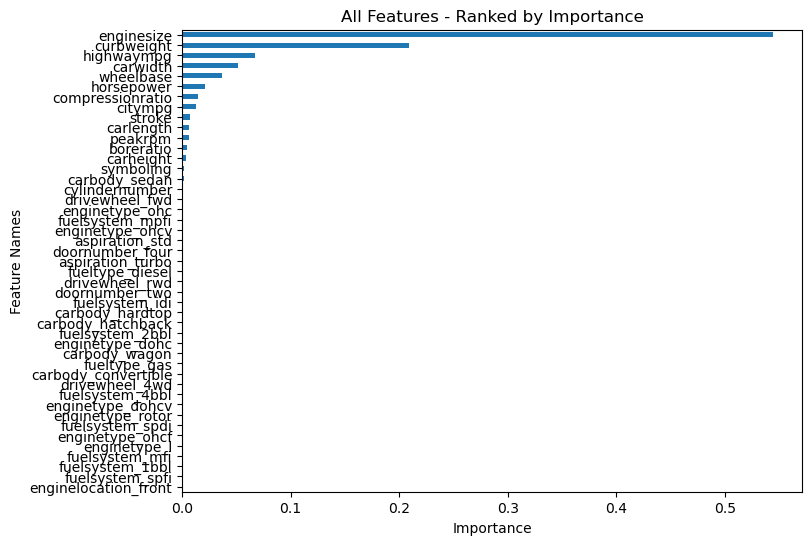

In [21]:
plot_importance(importances);

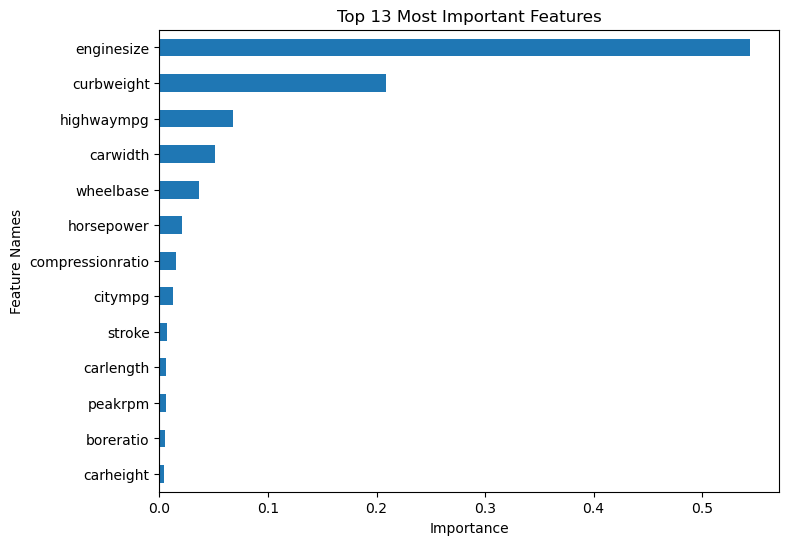

In [22]:
plot_importance(importances, top_n = 13);

### What were the 5 most important features?


In [23]:
importances.sort_values(ascending = False).head()

enginesize    0.543870
curbweight    0.208981
highwaympg    0.067479
carwidth      0.051535
wheelbase     0.036370
Name: Feature Importance, dtype: float64

- The 5 most important features were enginesize, curbweight, highwaympg, carwidth, and wheelbase.

### What does it mean that they were "important"?

- enginesize, curbweight, highwaympg, carwidth, and wheelbase are the most helpful features for this tree-based model to separate the data for predicting price of a car.
- enginesize is most important feature for predicting price.
- curbweight is the second most important.
- hgihwaympg, carwidth, and wheelbase are somewhat important.
- Everything else is unimportant.

### Permutation importance

In [24]:
r = permutation_importance(reg, X_test_df, y_test, n_repeats = 5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [25]:
# make the mean importances into a pandas series
permutation_importances = pd.Series(r['importances_mean'], index = X_test_df.columns, name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending = False)
permutation_importances

enginesize              0.706590
curbweight              0.145535
highwaympg              0.020326
horsepower              0.012759
wheelbase               0.012418
carwidth                0.010767
stroke                  0.003142
fuelsystem_mpfi         0.001831
drivewheel_fwd          0.001632
cylindernumber          0.001538
symboling               0.001375
carlength               0.001223
enginetype_ohc          0.001126
boreratio               0.001021
citympg                 0.000672
peakrpm                 0.000662
aspiration_turbo        0.000591
fueltype_diesel         0.000590
fuelsystem_2bbl         0.000524
aspiration_std          0.000521
doornumber_two          0.000490
fuelsystem_idi          0.000409
fueltype_gas            0.000406
doornumber_four         0.000255
carbody_hatchback       0.000159
carbody_wagon           0.000150
carbody_convertible     0.000139
carbody_hardtop         0.000066
drivewheel_rwd          0.000054
enginetype_ohcf         0.000051
enginetype

### Visualize the permutation importances

In [26]:
colors_top5 = get_color_dict(importances, top_n = 5)
colors_top5

{'symboling': '#006ba4',
 'wheelbase': 'green',
 'carlength': '#006ba4',
 'carwidth': 'green',
 'carheight': '#006ba4',
 'curbweight': 'green',
 'cylindernumber': '#006ba4',
 'enginesize': 'green',
 'boreratio': '#006ba4',
 'stroke': '#006ba4',
 'compressionratio': '#006ba4',
 'horsepower': '#006ba4',
 'peakrpm': '#006ba4',
 'citympg': '#006ba4',
 'highwaympg': 'green',
 'fueltype_diesel': '#006ba4',
 'fueltype_gas': '#006ba4',
 'aspiration_std': '#006ba4',
 'aspiration_turbo': '#006ba4',
 'doornumber_four': '#006ba4',
 'doornumber_two': '#006ba4',
 'carbody_convertible': '#006ba4',
 'carbody_hardtop': '#006ba4',
 'carbody_hatchback': '#006ba4',
 'carbody_sedan': '#006ba4',
 'carbody_wagon': '#006ba4',
 'drivewheel_4wd': '#006ba4',
 'drivewheel_fwd': '#006ba4',
 'drivewheel_rwd': '#006ba4',
 'enginelocation_front': '#006ba4',
 'enginetype_dohc': '#006ba4',
 'enginetype_dohcv': '#006ba4',
 'enginetype_l': '#006ba4',
 'enginetype_ohc': '#006ba4',
 'enginetype_ohcf': '#006ba4',
 'enginety

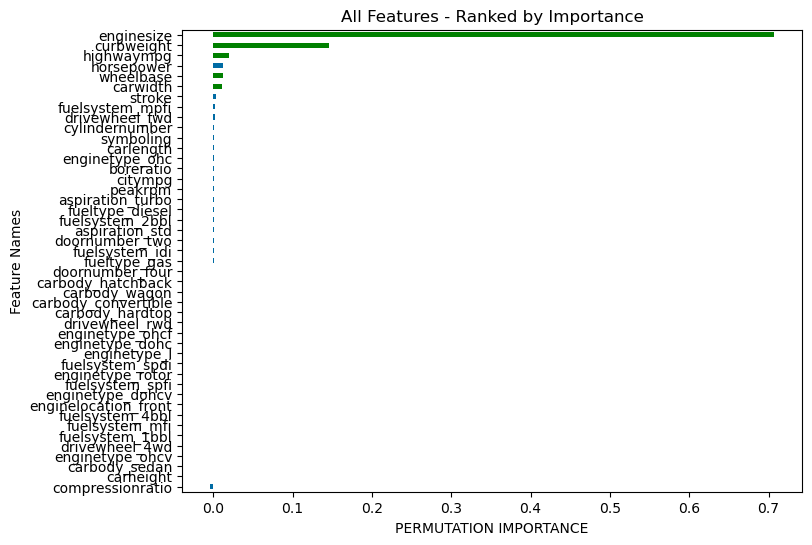

In [27]:
ax = plot_importance_color(permutation_importances, color_dict = colors_top5);
ax.set_xlabel("PERMUTATION IMPORTANCE");

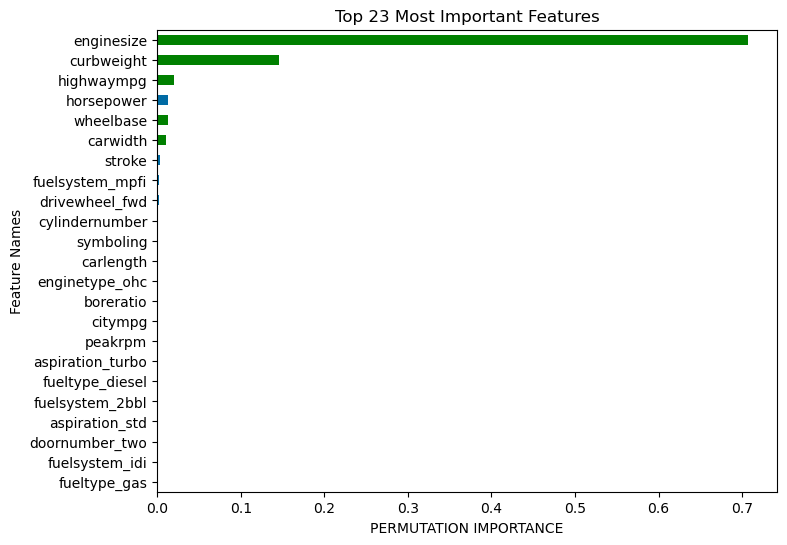

In [28]:
ax = plot_importance_color(permutation_importances, color_dict = colors_top5, top_n = 23);
ax.set_xlabel("PERMUTATION IMPORTANCE");

### What were your 5 most important features?

In [29]:
permutation_importances.sort_values(ascending = False).head()

enginesize    0.706590
curbweight    0.145535
highwaympg    0.020326
horsepower    0.012759
wheelbase     0.012418
Name: permutation importance, dtype: float64

- The 5 most important features when ranked by permutation importance were enginesize, curbweight, highwaympg, horsepower, and wheelbase.

### Are they the same features that your model has as the top 5 important?

- Four of the five features identified as the most important by the model were the same as those identified by permutation importance.
- enginesize, curbweight, highwaympg, and wheelbase were among the most helpful features for the model to separate the data.
- enginesize, curbweight, highwaympg, and wheelbase were also among the most helpful features for the model to separate the data when the bias towards valuing features with many values was removed through permutation importance.
- carwidth was an important feature for predicting price by the model, but horsepower was an important feature for predicting price when the bias towards valuing features with many values was removed.